# Week 4: Attention and Transformers
This notebook accompanies the week 4 lecture.

In [2]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'torch', 'matplotlib',
            'transformers', 'allennlp==0.9.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import transformers

from spacy.lang.en import English
# !python -m spacy download en_core_web_md
import en_core_web_md
en = English()
nlp = en_core_web_md.load()
# nlp = spacy.load('en_core_web_md')

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# this will set the device on which to train
device = torch.device("cpu")
# if using collab, set your runtime to use GPU and use the line below
#device = torch.device("cuda:0")

def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)])

def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

VersionConflict: (spacy 2.1.9 (/usr/local/lib/python3.7/site-packages), Requirement.parse('spacy<2.4.0,>=2.3.0'))

## Assignment 3 review tidbit
We should always be careful with our decompositions.  If they're using different features, fit on different data slices, they're not going to be directly comparable.

In [ ]:
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
X, _ = make_blobs(n_samples=100, centers=1, n_features=10,
                  random_state=0)
# take a random subsample
sub_idxs = np.where(np.random.random(len(X))<=0.25)
sub_X = X[sub_idxs]
print(sub_idxs)
# we're just going to pick a couple idxs and force them close
sampled_idxs = sub_idxs[0][:2]
X[sampled_idxs[0]] = X[sampled_idxs[1]]+0.1

pca_full = PCA(n_components=2)
pca_sub = PCA(n_components=2)
X_pca = pca_full.fit_transform(X)
X_pca_sub = pca_sub.fit_transform(sub_X)
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
axs[0].scatter(X_pca[:,0], X_pca[:,1])
axs[0].scatter(X_pca[sampled_idxs,0], X_pca[sampled_idxs,1], color='r')
axs[1].scatter(X_pca_sub[:,0], X_pca_sub[:,1])
axs[1].scatter(X_pca_sub[:2,0], X_pca_sub[:2,1], color='r')

## General data formatting
Usually, you'd want a set of functions to carry out most of this.  But for now, we're just including it here.

In [3]:
# you will need to change this to where ever the file is stored
data_location = './data/assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
# join all reviews
all_reviews = np.array(neg+pos)
# create binary indicator for positive review
is_positive = np.array([0]*len(neg)+[1]*len(pos))
# set the seed for numpy
np.random.seed(seed=42)
# shuffle, just for safety
shuffled_idxs = np.random.choice(range(len(all_reviews)), size=len(all_reviews),replace=False)
all_reviews = all_reviews[shuffled_idxs]
is_positive = is_positive[shuffled_idxs]
# sample random 70% for fitting model (training)
# we'll also add a validation set, for checking the progress of the model during training
# 30% will be simulating "new observations" (testing)
pct_train = 0.7
train_bool = np.random.random(len(all_reviews))<=pct_train
reviews_train = all_reviews[train_bool]
reviews_test = all_reviews[~train_bool]
is_positive_train = is_positive[train_bool]
is_positive_test = is_positive[~train_bool]
# making a validation set
pct_val = 0.3
val_idxs = np.random.random(size=len(reviews_train))<=pct_val
is_positive_val = is_positive_train[val_idxs]
is_positive_val.shape
reviews_val = reviews_train[val_idxs]
# reconfigure train so that it doesn't include validation
reviews_train = reviews_train[~val_idxs]
is_positive_train = is_positive_train[~val_idxs]
print('Train: {0} \nValidation: {1} \nTest: {2}'.format(
    len(reviews_train), len(reviews_val), len(reviews_test)))
parsed_train = [simple_tokenizer(str(d)) for d in reviews_train]
parsed_val = [simple_tokenizer(str(d)) for d in reviews_val]
parsed_test = [simple_tokenizer(str(d)) for d in reviews_test]

Train: 1233 
Validation: 535 
Test: 731


NameError: name 'simple_tokenizer' is not defined

In [8]:
# construct glove weight matrix
# construct vocab
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=0.01)
cv.fit(parsed_train)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))
vocab = cv.vocabulary_
vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector
# additional formatting
idx_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(idx_train)
idx_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(idx_val)
idx_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(idx_test)

Size of vocab: 1765


## Bi-directional LSTMs and ELMo
ELMo's architecture extends on what we've already learned about LSTM models.  ELMo uses a bi-directional LSTM, which is simply two connected LSTMs that step through each observation in opposite directions.  Incidentally, we can adapt our existing LSTM model to be bi-direction very easily.  In our SentimentNet model, just replace the line:

`self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob, batch_first=True)`

with 

`self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob, batch_first=True, bidirectional=True)`

We won't implement that here, but feel free to try it on your own time.

ELMo, unlike our SentimentNet, is trained as a "language model".  That means its objective is to predict the next word given the context.  So at time t, it combines the representation from t-1 (the forward LSTM) and the representation from t+1 (the backward LSTM) to predict the word.  The representations from this model, trained on the language modelling task, can then be used as contextualized word-level embeddings.

For this example, we'll look at a case of [polysemy](https://en.wikipedia.org/wiki/Polysemy), where the word "stick" can mean "keep with" or a piece of a tree, depending on context.

The `allennlp` library has a great, simple implementation of ELMo for transfer learning.  

In [9]:
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

100%|██████████| 374434792/374434792 [10:47<00:00, 578581.28B/s] 


In [11]:
docs = ["Let's stick to the script",
       "I threw the stick to the dog",
       "We should stick together"]

# elmo embedder expects a list of tokens
token_docs = [simple_tokenizer(d) for d in docs]
elmo_vecs = [elmo.embed_sentence(d) for d in token_docs]
elmo_vecs[0].shape

(3, 5, 1024)

The output of the `ElmoEmbedder` contains three vectors of length 1024 for each word.  From [the paper](https://arxiv.org/pdf/1802.05365.pdf), the architecture of the model is an embedding layer and two Bi-directional LSTMs (two sets of forward and backward).  So, we have three representations of each word.

There's learning incorporated into each of these layers, but we'll be using the last layer.  Other implementations of ELMo use a weighted combination of all three.

In [12]:
# first document in corpus
first_doc = elmo_vecs[0]
print(first_doc.shape)
# last layer
first_doc_last_layer = first_doc[-1]
print(first_doc_last_layer.shape)
# first word's embedding ("Let")
print(first_doc_last_layer[0].shape)

(3, 5, 1024)
(5, 1024)
(1024,)


### Exercise: Polysemy in GloVe and ELMo
Using GloVe and ELMo, get the embeddings for the word "stick" in different contexts (i.e. doc 1 and 3 vs doc 2).  Compare their cosine similarity and interpret.

If you finish this quickly, see if you can come up with other examples to test this out.

In [13]:
layer_idx = -1
word = 'stick'
elmo_word_vecs = [s[layer_idx][token_docs[i].index(word)] for i, s in enumerate(elmo_vecs)]
cosine_similarity(elmo_word_vecs)

array([[1.0000002 , 0.6649847 , 0.69462466],
       [0.6649847 , 1.0000001 , 0.6093911 ],
       [0.69462466, 0.6093911 , 1.0000002 ]], dtype=float32)

Note that doc 1 and doc 3 that use "stick" in the "keep with" sense have higher similarity than doc 2, which uses the "piece of tree" context.

With GloVe, each word is considered without context.  So stick in doc 1 and doc 2 have the same vector:

In [14]:
parsed_docs = [nlp(d) for d in docs]
print(parsed_docs[0][2])
print(parsed_docs[2][2])
cosine_similarity(
    parsed_docs[0][2].vector.reshape(1,-1),
    parsed_docs[1][2].vector.reshape(1,-1))

stick
stick


array([[0.35833034]], dtype=float32)

The trade-off here is it's not so easy to just create a ELMo word embedding vector, because a word's embedding depends on its context.  Feel free to try it out in our SentimentNet model, but remember this requires running all reviews through ELMo and creating a much larger embedding matrix.

ELMo is still a recurrent model.  We talked about some issues that face recurrent models such as vanishing gradients.  LSTMs solve that to some extent and the bi-directional nature of ELMo also addresses that.  

But with large documents, context is pretty widely distributed.  LSTMs, no matter how they're shaped, are going to be biased towards nearby information.  We need some way to make sure, for each token, we're incorporating information relevant to THAT token, even if that information occurs many tokens in the past.  One way to do that:

## Attention

There's more detail about attention in the slides, but briefly, attention is a name for a set of techniques that weight certain inputs to increase signal and decrease noise. 

We'll be focusing on self-attention, in which we are weighting components of a particular sequence relative to individaul components of that same sequence.  With text that typically means having our document representation incorporate information not just from its neighbors, but from the entire document.

We'll be taking our existing SentimentNet model and incorporating a simple implementation of self-attention.  In this case, we're weighting the hidden states by the dot product of the word embeddings.

In [15]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

    def forward(self, embeds, hidden):
        # getting the shape information
        batch_size, output_len, dimensions = embeds.size()
        # attention scores
        attention_scores = torch.bmm(embeds, embeds.transpose(1, 2).contiguous())
        attention_scores = attention_scores.view(batch_size * output_len, output_len)
        # normalize
        attention_weights = nn.functional.softmax(attention_scores)
        attention_weights = attention_weights.view(batch_size, output_len, output_len)
        # weight hidden layer
        mix = torch.bmm(attention_weights, hidden)
        # output result
        return mix, attention_weights

In [16]:
class SentimentNet(nn.Module):
    # sentiment classifier with single LSTM layer + Fully-connected layer, sigmoid activation and dropout
    # adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=1, # mistake on previous notebooks, just 1 layer here 
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        # size of the output, in this case it's one input to one output
        self.output_size = output_size
        # number of layers (default 2) one LSTM layer, one fully-connected layer
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        # LSTM layer, where the magic happens
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout, similar to regularization
        self.dropout = nn.Dropout(dropout_prob)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # sigmoid activiation
        self.sigmoid = nn.Sigmoid()
        # adding attention layer
        self.attn = Attention(hidden_dim)
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        # run input embedding + hidden state through model
        lstm_out, hidden = self.lstm(embeds, hidden)
        # implementing attention
        weighted_out, attention_weights = self.attn(embeds, lstm_out)
        # using weighted output intstead of lstm output
        # reshape
        weighted_out = weighted_out.contiguous().view(-1, self.hidden_dim)
        # dropout certain pct of connections
        out = self.dropout(weighted_out)
        # fully connected layer
        out = self.fc(out)
        # activation function
        out = self.sigmoid(out)
        # reshape
        out = out.view(batch_size, -1)
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, attention_weights, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [17]:
model_params = {'weight_matrix': glove_vecs,
               'output_size': 1,
               'hidden_dim': 512,
               'n_layers': 1,
               'embedding_dim': 400,
               'dropout_prob': 0.20}
training_params = {'learning_rate': 0.005,
                  'epochs': 1,
                  'batch_size': 100}
batch_size = training_params['batch_size']
# construct datasets for loading by PyTorch
train_data = TensorDataset(torch.from_numpy(padded_train), torch.from_numpy(is_positive_train))
val_data = TensorDataset(torch.from_numpy(padded_val), torch.from_numpy(is_positive_val))
test_data = TensorDataset(torch.from_numpy(padded_test), torch.from_numpy(is_positive_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,
                       drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,
                        drop_last=True)

In [18]:
model = SentimentNet(**model_params)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                         lr=training_params['learning_rate'])
# increasing this will make the training take a while on CPU
# decrease to 5 if it's taking too long
epochs = training_params['epochs']
batch_size = training_params['batch_size']
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h, train_attention_weights, lstm_out = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h, val_attention_weights, _ = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 1/1... Step: 5... Loss: 0.704546... Val Loss: 0.712450
Validation loss decreased (inf --> 0.712450).  Saving model ...
Epoch: 1/1... Step: 10... Loss: 0.948129... Val Loss: 0.775699


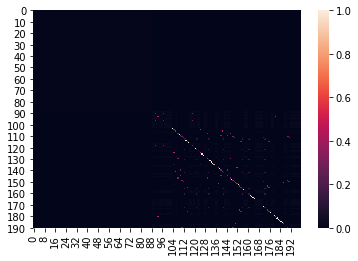

In [19]:
# take a look at the weights, for just one observation
# what dimensions do we expect? (attention is with respect to all other states in sequence)
#train_attention_weights[0].shape
# knowing that our weights are just a dot-product of the word vectors...what should they be?
# specifically, where will be the highest weights?
# I'm making a useful viz here, but you don't need to wrangle with seaborn
#!pip install seaborn
import seaborn as sns
sns.heatmap(train_attention_weights[0].detach().cpu())
#np.argmax(train_attention_weights[0].detach().cpu(), axis=1)

## Bidirectional Encoder Representations from Transformers (BERT)
In 2018, researchers from Google released a [landmark paper](https://arxiv.org/pdf/1810.04805.pdf) that represented a major advancement in NLP.  It incorporated the concepts of Encoder-Decoder architectures with Attention to create an architecture that outperformed the state-of-the-art on a variety of tasks.  

One of the most powerful features of BERT is that it can be pre-trained on a set of tasks that don't require labelled data.  One of them is the language modelling task we've discussed before (i.e. predicting the next word).  The other is predicting whether one sentence follows another.  The model, trained on these two tasks, can produce representations that incorporate both syntactic and semantic information.

We'll be using the `transformers` library from [HuggingFace](https://huggingface.co/transformers/) to leverage a pre-trained version of BERT.

In [20]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM

In [21]:
# basic pretrained model (case-insensitive)
MODEL_NAME = 'bert-base-uncased'
# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [22]:
# adapted from https://github.com/huggingface/transformers/blob/master/notebooks/02-transformers.ipynb
# tokenize according to BERT tokenization design
tokens = tokenizer.tokenize("This is an input example")
print("Tokens: {}".format(tokens))

# transform to ids for model
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens id: {}".format(tokens_ids))

# Add the required special tokens ([CLS] and [SEP])
tokens_ids = tokenizer.build_inputs_with_special_tokens(tokens_ids)
print("Tokens id: {}".format(tokens_ids))
print("Tokens + special tokens: {}".format(
    tokenizer.convert_ids_to_tokens(tokens_ids)))

# convert to tensor (PyTorch)
tokens_pt = torch.tensor([tokens_ids])

# Now we're ready to go through BERT with out input
outputs, pooled = model(tokens_pt)
print("Token wise output: {}, Pooled output: {}".format(outputs.shape, pooled.shape))

Tokens: ['this', 'is', 'an', 'input', 'example']
Tokens id: [2023, 2003, 2019, 7953, 2742]
Tokens id: [101, 2023, 2003, 2019, 7953, 2742, 102]
Tokens + special tokens: ['[CLS]', 'this', 'is', 'an', 'input', 'example', '[SEP]']
Token wise output: torch.Size([1, 7, 768]), Pooled output: torch.Size([1, 768])


The model gives two outputs: a token-level representation of length 768 (i.e. one 768-element representation per token) and a sentence-level representation of length 768.

Let's return to the example above and see how the word-level representation deals with polysemy.

Note: `BertTokenizer` has a method that implements all of the tokenization steps above in one line for multiple sentences/documents.

In [23]:
docs = ["Let's stick to the script",
       "I threw the stick to the dog",
       "We should stick together"]

tokens = tokenizer.batch_encode_plus(docs,
    pad_to_max_length=True, # this implements padding for different length docs
    return_tensors="pt") # returning as pytorch tensors

outputs, pooled = model(**tokens)
print(outputs.shape)

torch.Size([3, 7, 768])


In [24]:
word = 'stick'
token_id = tokenizer.convert_tokens_to_ids('stick')
token_idx = np.where(tokens['input_ids']==6293)[1]
bert_word_vecs = [d[token_idx[i]].detach().numpy() for i, d in enumerate(outputs)]
cosine_similarity(bert_word_vecs)

array([[1.        , 0.5758077 , 0.55566835],
       [0.5758077 , 1.0000002 , 0.5319526 ],
       [0.55566835, 0.5319526 , 1.0000002 ]], dtype=float32)

Similar to ELMo, the similarity between doc 1 and doc 3's embedding for "stick" is higher than doc 1 and doc 2's embedding for "stick.

Let's make use of the document-level embedding.  Let's take a random set of negative and positive reviews and look at the similarity within and between classes.

### Exercise: Intra- and inter-class similarity using BERT

Sample five negative and five positive reviews.  Run them through `tokenizer.batch_encode_plus`.  Then take the "pooled" (document-level) representation and run cosine similarity to get the inter-class and intra-class similarities.

You may get some warnings! Read them, and think about why they're appearing.

Note: The reason you're taking only 10 reviews is because BERT takes a bit to run.  Feel free to take a larger sample if you have time.

In [25]:
# select random set of neg/pos
neg_sample = np.random.choice(neg, size=5)
pos_sample = np.random.choice(pos, size=5)
full_sample = np.concatenate([neg_sample, pos_sample])
tokens = tokenizer.batch_encode_plus(full_sample,
    pad_to_max_length=True, # this implements padding for different length docs
    return_tensors="pt") # returning as pytorch tensors


Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


In [26]:
# select random set of neg/pos
np.random.seed(42)
neg_sample = np.random.choice(neg, size=5)
pos_sample = np.random.choice(pos, size=5)
full_sample = np.concatenate([neg_sample, pos_sample])
tokens = tokenizer.batch_encode_plus(full_sample,
    pad_to_max_length=True, # this implements padding for different length docs
    return_tensors="pt", # returning as pytorch tensors
    max_length=512) # this BERT model has a max sequence length of 512 tokens

outputs, pooled = model(**tokens)
print(outputs.shape)

torch.Size([10, 512, 768])


In [27]:
bert_vecs = pooled.detach().numpy()
bert_sims = cosine_similarity(bert_vecs)
print('Neg to neg:',(bert_sims[:5, :5]).mean().mean())
print('Neg to pos:',(bert_sims[:5, 5:]).mean().mean())
print('Pos to pos:',(bert_sims[5:, 5:]).mean().mean())

Neg to neg: 0.61842924
Neg to pos: 0.5142101
Pos to pos: 0.5706985


Interesting! So negative reviews' review-level representations are more similar to other negative reviews and less similar to poisitive reviews.  The same is true for positive reviews, though the difference is not as large.  Of course, this is a small subset of the complete data, so it's hard to draw conclusions.  But this gives you a method for making use of the document-level representations from pretrained BERT.

In [28]:
# basic pretrained model (case-insensitive)
MODEL_NAME = 'distilbert-base-uncased'
# Load pre-trained model
model = DistilBertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

NameError: name 'DistilBertModel' is not defined

In [ ]:
# select random set of neg/pos
neg_sample = np.random.choice(neg, size=5)
pos_sample = np.random.choice(pos, size=5)
full_sample = np.concatenate([neg_sample, pos_sample])
tokens = tokenizer.batch_encode_plus(full_sample,
    pad_to_max_length=True, # this implements padding for different length docs
    return_tensors="pt") # returning as pytorch tensors

In [ ]:
st = 0
# batch-wise, otherwise tends to take a long time
batches = list(range(100, len(data), 100))+[len(data)]
doc_rep_collector = []
for b in batches:
    tokens = tokenizer.batch_encode_plus(data['text'][st:b],
      pad_to_max_length=True, return_tensors="pt")
    st = b
    outputs = model(**tokens)
    # taking the representation of the 'CLS' token (doc-level embedding)
    doc_rep_collector.append(outputs[0][:,0].detach().numpy())
    break
doc_rep_collector = np.concatenate(doc_rep_collector)